# Terminal

In [11]:
# !pip install tensorflow_text

  Using cached tensorflow_text-2.10.0-cp310-cp310-win_amd64.whl (5.0 MB)


# Import libraries

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import pickle

# Create dataframe

In [15]:
df1 = pd.read_csv('./war-news.csv')
df1.shape

(5653, 6)

In [16]:
df1['news_headline'] = df1['Headlines']
df1['category_num'] = 1

In [17]:
df1 = df1.drop(columns=['Unnamed: 0', 'Summary', 'Press', 'Date', 'Keyword', 'Headlines'])
df1.head()

,news_headline,category_num
0,I served in Iraq and Afghanistan but the horro...,1
1,The forever war in Afghanistan is nowhere near...,1
2,"Hell at Abbey Gate: Chaos, Confusion and Death...",1
3,�A second Afghanistan�: Doubts over Russia�s w...,1
4,Afghanistan: Former army general vows new war ...,1


In [18]:
df2 = pd.read_csv('./inshort_news_data-1.csv')
df2.shape

(4817, 4)

In [19]:
df2['category_num'] = 0

In [20]:
df2 = df2.drop(columns=['Unnamed: 0','news_article', 'news_category'])
df2.head()

,news_headline,category_num
0,50-year-old problem of biology solved by Artif...,0
1,Microsoft Teams to stop working on Internet Ex...,0
2,Hope US won't erect barriers to cooperation: C...,0
3,Global smartphone sales in Q3 falls 5.7% to 36...,0
4,EU hoping Biden will clarify US position on di...,0


In [21]:
df = pd.concat([df1, df2], ignore_index=True)
df

,news_headline,category_num
0,I served in Iraq and Afghanistan but the horro...,1
1,The forever war in Afghanistan is nowhere near...,1
2,"Hell at Abbey Gate: Chaos, Confusion and Death...",1
3,�A second Afghanistan�: Doubts over Russia�s w...,1
4,Afghanistan: Former army general vows new war ...,1
...,...,...
10465,AstraZeneca to test combining Oxford vaccine w...,0
10466,"Humanity will face 60°C temperatures in 2050s,...",0
10467,Human-made objects to outweigh living things b...,0
10468,"IUCN lists 31 species as 'Extinct', European B...",0


# Create NN

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['news_headline'],df['category_num'], stratify=df['category_num'])

In [23]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [24]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
%%timeit -n1 -r1 
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=5)

Epoch 1/5
246/246 [==============================] - 98s 399ms/step - loss: 0.5785 - accuracy: 0.7198
Epoch 2/5
246/246 [==============================] - 99s 402ms/step - loss: 0.4657 - accuracy: 0.8197
Epoch 3/5
246/246 [==============================] - 97s 395ms/step - loss: 0.4110 - accuracy: 0.8469
Epoch 4/5
246/246 [==============================] - 104s 425ms/step - loss: 0.3710 - accuracy: 0.8654
Epoch 5/5
246/246 [==============================] - 96s 390ms/step - loss: 0.3506 - accuracy: 0.8683
8min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
model.evaluate(X_test, y_test)

82/82 [==============================] - 33s 388ms/step - loss: 0.3167 - accuracy: 0.9030


[0.3167063295841217, 0.9029793739318848]

In [58]:
reviews = [
    'South Africa summons US ambassador over his claims it is arming Russia',
    'war kill',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 0s 173ms/step


array([[0.5713513 ],
       [0.85098857],
       [0.4318136 ],
       [0.32966498],
       [0.5619367 ]], dtype=float32)

In [37]:
model.save("saved_models/1/")

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets


In [50]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

82/82 [==============================] - 32s 389ms/step


In [51]:
y_predicted

array([0.725078  , 0.17285171, 0.7136295 , ..., 0.94769526, 0.6754854 ,
       0.93885267], dtype=float32)

In [52]:
import numpy as np

y_predicted = np.where(y_predicted > 0.7, 1, 0)
y_predicted

array([1, 0, 1, ..., 1, 0, 1])

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1186,   18],
       [ 445,  969]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

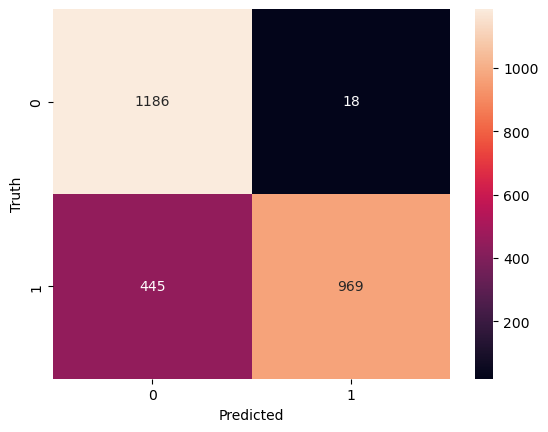

In [54]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [55]:
for i in range(len(y_predicted)):
    if y_predicted[i] == 1:
        print(df['news_headline'][i])

I served in Iraq and Afghanistan but the horrors of war turned me into an 
�120 an hour sex worker...
Hell at Abbey Gate: Chaos, Confusion and Death in the Final Days of the War 
in Afghanistan
Afghanistan: Former army general vows new war against Taliban
A Year After Biden's Announcement, Afghanistan Is Now Someone Else's 
Problem | Opinion
Ukraine war could worsen crises in Yemen and Afghanistan
The war in Ukraine is exacerbating food insecurity in ...
The Afghan War May Not Be Over
This Is No Time to Disengage from Afghanistan's War
India, Italy talk Afghanistan situation, Ukraine war � Pajhwok ...
Russia-Ukraine war: Meet the Afghan refugees fighting ...
New York Times wins 3 Pulitzer Prizes, Reuters wins for feature photography
Red Cross chief on Iran visit talks Afghans' plight
'I Want to Meet With the Taliban': Tales of Trump's Head ...
Zarifa Ghafari Says She'll Never Stop Fighting For Afghan ...
Russia may declare war on Ukraine on May 9 � and use it as a reason to 
double dow